[View in Colaboratory](https://colab.research.google.com/github/ioanachelu/PracticalSessions/blob/master/Rosedu_RL_workshop.ipynb)

#RL Tutorial 

Designed for education purposes. Please do not distribute without permission.

Questions/Correspondence: 2018tmlss@gmail.com

Special thanks to: Hado van Hasselt, Matteo Hessel

Original repo and solution: https://github.com/tmlss2018/PracticalSessions/blob/master/rl/RL_full.ipynb

Credits and acknoledgements to TMLSS lab instructors: https://tmlss.ro/ (David Szepesvari - introductory, Viorica Patraucean - vision, Wojtek Czarnecki - rnn, Mihaela Rosca - generative, Diana Borsa - rl)

## Content

In this tutorial, we will investigate the properties of 3 distinct reinforcement learning algorithms:

* Policy Evaluation
* Online Control: SARSA, Q-learning
* Experience Replay
* REINFORCE Algorithm 

Some dimensions of the RL problems we will be considering:
* Tabular vs Function Approximation
* Off-policy/On-policy Control
* Online vs Replay
* Exploration vs Exploitation 


## Background reading

* Sutton and Barto (2018), Chapters 3-8

## Objectives

You will use Python to implement several reinforcement learning algorithms. Only the second part will deal with functional approximation for which we will be using neural networks to approximate value functions and policies.

You will then run these algorithms on a few problems, to understand their properties and different emerging behaviour. In this tutorial we will focus primarily on fundamental algorithms in RL and explore them in a simple gridworld setting. That being said, these are algorithms that have now been shown to scale very well with (non-linear) functional approximations. 


# Setup

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import itertools
import tensorflow as tf


np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

tf.logging.set_verbosity(tf.logging.ERROR)

## Environments: Grid-Worlds

**(Simple) Tabular Grid-World**

You can visualize the grid worlds we will train our agents on, by running the cells below.
`S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise -- unless configurated/stated otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.

We will use two distinct GridWorlds:
* `Grid` tabular grid world with a goal in the top right of the grid
* `AltGrid` tabular grid world with a goal in the bottom left of the grid

In [0]:
#@title Environment: Gridworld Implementation
class Grid(object):

  def __init__(self, discount=0.9, penalty_for_walls=-5):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0, -1,  0,  0, -1],
      [-1,  0,  0,  0, -1,  0,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout <= -1, interpolation="nearest")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()

In [0]:
#@title Alternative Environment: Gridworld (with different goal state)
class AltGrid(Grid):
  
    def __init__(self, discount=0.9, penalty_for_walls=-5):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  -1,  0,  0, -1],
        [-1,  0,  0,  0, -1,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount
      self._penalty_for_walls = penalty_for_walls

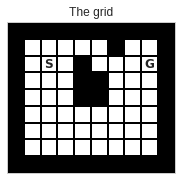

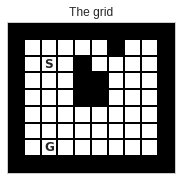

In [0]:
# Visualise the two environments

# Instantiate the two tabular environments
grid = Grid()
alt_grid = AltGrid()

# Plot tabular environments
grid.plot_grid()
alt_grid.plot_grid()

In [0]:
#@title Policies

# uniformly random policy
def random_policy(q):
  return np.random.randint(4)

# epilson-greedy policy
def epsilon_greedy(q_values, epsilon=0.1):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

## Helper functions

In [0]:
#@title Helper functions for visualisation

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
      
  
def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)
  

def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

In [0]:
#@title [IMPORTANT] Running the experiments
# 1) Interact with the environment
# 2) Agent gets observation, rewards, and discount 
# from env. and produces the next action
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
      
    # Interaction wih the MDP
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

In [0]:
#@title Helper functions for running experiments
def plot_policy(grid, policy):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  grid.plot_grid()
  plt.hold('on')
  plt.title('Policy Visualization')
  for i in range(9):
    for j in range(10):
      action_name = action_names[policy[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  plt.title('Greedy Policy')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

# RL Lab 1: Tabular Agents

Each agent should implement a step function:

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `q_values()`:

Tabular agents implement a function `q_values()` returning a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

### `q_values(state)`:

Agents with Linear function approximation implement a method `q_values(state)` returning an array of Q values of shape: (`number_of_actions`)


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  


## 1.0: Overview

We are going to implement:
- Prediction problem: Policy Evaluation
- Towards control: Greedy Improvement 
- Online Tabular SARSA Agent
- Online Tabular Q-learning Agent
- Tabular Experience Replay Q-learning Agent








## 1.1: Policy evaluation and Greedy Improvement









The purpose here is to evaluate a given policy $\pi$ -- compute the value function associated with following/employing this policy in a given MDP.

$$ Q^{\pi}(S,A) = \mathbb{E}_{\tau \sim P^{\pi}} [\sum_t \gamma^t R_t| s_0=s,a=a_0]$$

where $\tau = \{s_0, a_0, r_0, s_1, a_1, r_1, \cdots \}$


Algorithm:

**Initialize** $Q(s, a)$ for all s ∈ $\mathcal{S}$ and a ∈ $\mathcal{A}(s)$

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{behaviour_policy}(S)$
 
3. Take action $A$; observe resulting reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma Q(S', \pi(S')) − Q(S, A))$

In [0]:
# uniformly random policy
def random_policy(q):
  return np.random.randint(4)

def greedy_policy(q):
  return np.argmax(q)

In [0]:
#@title Exercise: Implement Policy Evaluation Agent
class PolicyEval_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, evaluated_policy, 
      behaviour_policy=random_policy, step_size=0.1):
    self._action = 0
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    
    # ============ YOUR CODE HERE =============
    # initialize your q-values (this is a table of state and action pairs
    # Note: this can be random, but the code was tested w/ zero-initialization 
    # self._q =
    pass
  
  @property
  def q_values(self):
    pass

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # ============ YOUR CODE HERE =============
    # Q-value table update
    pass
  
    # Get the action to send to execute in the environment and return it
    pass
    
    return self._action
    

**Task 1**: Run the policy evaluation agent, evaluating the uniformly randon policy  on the AltGrid() environment for $\texttt{num_steps} = 1e3, 1e5$. 

Visualise the resulting value functions $Q(s,a)$. Plotting function is provided for you and it takes in a table of q-values

AFTER 100000 STEPS ...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python2.7/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


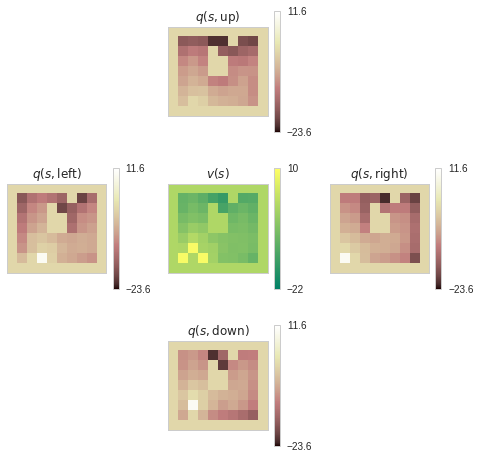

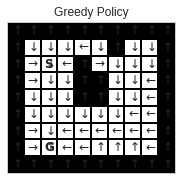

In [0]:
num_steps = int(1e5) # @param

# environment
grid = AltGrid()

# agent 
agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

plot_greedy_policy(grid, q)

**Task 2: [Greedy Policy Improvement]** Compute and Visualise the greedy policy based on the above evaluation, at the end of the training process for $\texttt{num_steps} = 1e5$.


$$ \pi_{greedy} (a|s) = \arg\max_a q^{\mu}(s,a)$$


**Q: ** What do you observe? (Remember that we are evaluating the uniformly random policy)

In [0]:
# @title Exercise: Implement epilson-greedy policy
# Input: Q(s,:), epsilon
# Output: Sampled action based on epsilon-Greedy(Q(s,:))
# epilson-greedy policy
def epsilon_greedy(q_values, epsilon=0.1):
  pass
  #return the epsilon greedy action

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.


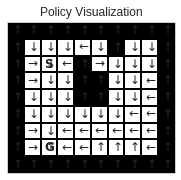

In [0]:
# Visualize the greedy policy (whatever works for you, 
# but you should be able to see what the agent would do
# at each step/state)  

pi = np.zeros((9,10), dtype=np.int32)
for i in range(9):
  for j in range(10):
    pi[i, j] = epsilon_greedy(q[i, j], epsilon=0.)
    
plot_policy(grid, pi)

**Task 3**: Re-run the same experiment: policy evaluation agent on the Grid() environment for $\texttt{num_steps} = 1e5$
and visualise the resulting value functions and the greedy policy on top of these values at the end of training.

**Q: ** What do you observe? 
- How does this policy compare with the optimal one?
- Try running the training process longer -- what do you observe?

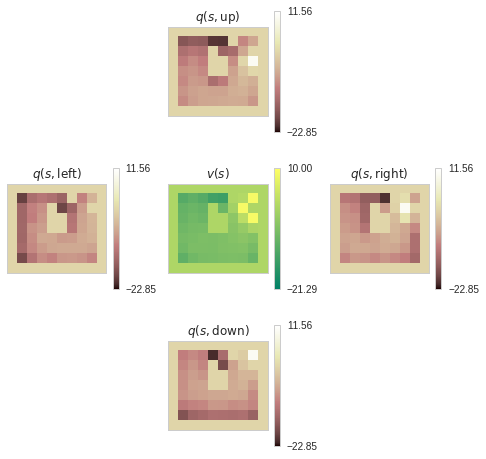

In [0]:
num_steps = int(1e6) # @param

grid = Grid()

agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
plot_action_values(q)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app


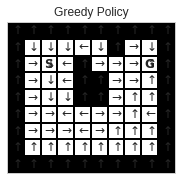

In [0]:
# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.2 On-policy control: SARSA Agent
In the following we are going to be concern with the control problem -- inferring the optimal value/policy that will 'solve' the MDP. The first algorithm we are going to be looking at is SARSA. 

Note: This is an **on-policy algoritm** -- i.e: the data collection is done on-policy.


**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{current_policy}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma Q(S', A') − Q(S, A))$

In [0]:
#@title Exercise: Implement SARSA Agent
class SARSA_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._action = 0
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # ============ YOUR CODE HERE =============
    # Q-value table update
    # td_error =
    # self._q[s, a] =
    pass
    
     # Get the action to send to execute in the environment and return it
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

**Task**: Run the SARSA agent with different levels of exploration. 

- Moderate exploration: $\texttt{epsilon} = 0.1$. 

- Very exploratory strategy: $\texttt{epsilon} = 0.5, 1.0$.

**Q**: Which do you expect, without running the experiment, to do better?  

 **Run multiple times**: What do you observe? ($\texttt{epsilon} = 0.1$)




AFTER 100000 STEPS ...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app


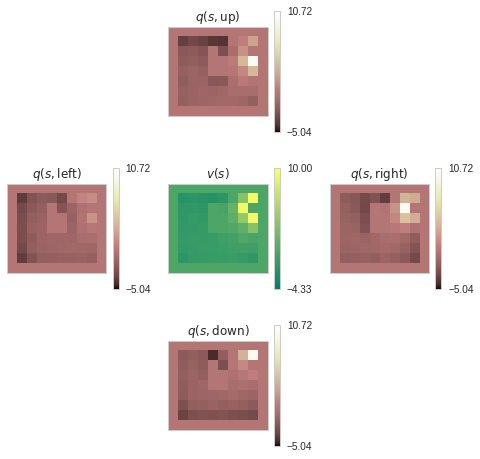

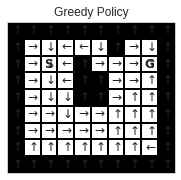

In [0]:
epsilon = 1 #@param
num_steps = int(1e5) #@param

grid = Grid(discount=0.9, penalty_for_walls=-1.)

behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)
agent = SARSA_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.2 Off-policy control: Q-learning Agent

Reminder: Q-learning is a very powerful and general algorithm, that enable control (figuring out the optimal policy/value function) both on and off-policy.

**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{behaviour_policy}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
#@title Exercise: Implement Q-learning Agent 
class Qlearning_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    pass
    
  @property
  def q_values(self):
    pass

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # ============ YOUR CODE HERE =============
    # Q-value table update
    pass
  
    # Get the action to send to execute in the environment and return it
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

### Task 1: Run your Q-learning agent on the below environment for 1e5 number of steps
Keep the rest, to the default values, for this first step. I'll get to experiment with this later.

In [0]:
# enviroment
grid = Grid(discount=0.9, penalty_for_walls=-1.)

AFTER 100000 STEPS ...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app


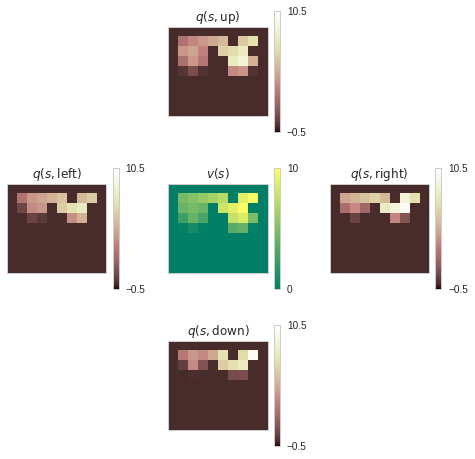

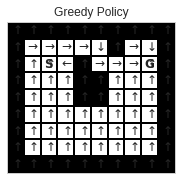

In [0]:
epsilon = 0.1 #@param
num_steps = int(1e5) #@param

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = Qlearning_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

### Task 2: Experiment with different levels of 'greediness':
* The default was $\epsilon=1$, what does this correspond to?
* Try also $\epsilon =0.1, 0.5$. What do you observe? Does the behaviour policy affect the training in any way?

## 1.3 Experience Replay

 Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning 
* apply multiple Q-learning updates based on transitions sampled from the *replay buffer* (in addition to the online updates).

**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S, a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
 class ReplayQ_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._num_offline_updates = num_offline_updates
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    
    # initialise replay buffer
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # Online Q-value update
    td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
    self._q[s, a] += self._step_size * td_error
    
    # ============ YOUR CODE HERE =============
    if self._num_offline_updates > 0:

      # Store sample into replay buffer memory

      
      # ============ YOUR CODE HERE =============
      # Q-value table update based on online sample and offline samples
      # This update is the same as the above (Q-learning Agent) but 
      # now we are going to be using samples from the replay buffer.
      # Note: You can COPY this from the above Q_learning Agent
       pass

      # Get the action to send to execute in the environment and return it
      self._state = next_state
      self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

AFTER 10000 STEPS ...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app


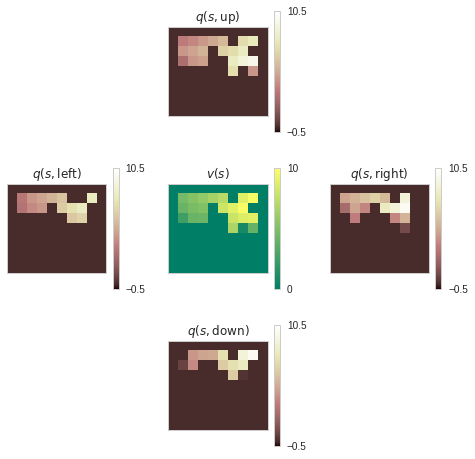

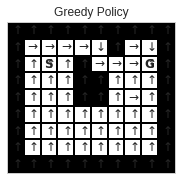

In [0]:
num_offline_updates=30 #@param
num_steps = int(1e4) #@param

grid = Grid(discount=0.9, penalty_for_walls=-1.)

behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)
agent = ReplayQ_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    num_offline_updates=num_offline_updates, 
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.4 Further Analysis:  Data Efficiency

**Online Q-learning**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app


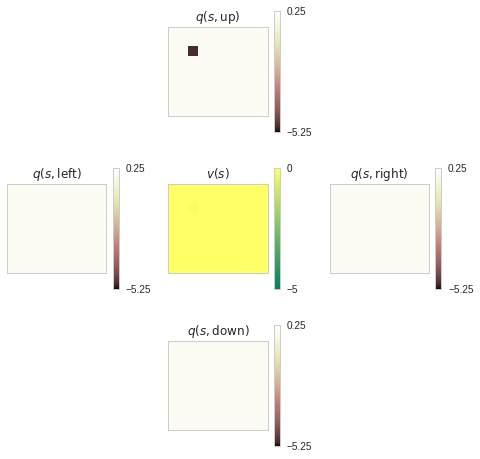

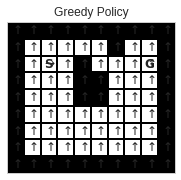

In [0]:
grid = Grid()
agent = ReplayQ_AGENT(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
# visualise the greedy policy
plot_greedy_policy(grid, q)

**Experience Replay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app


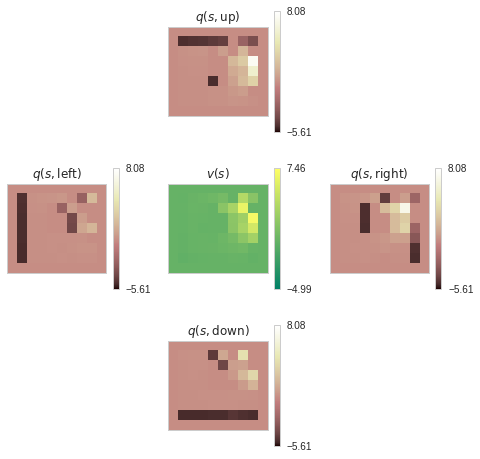

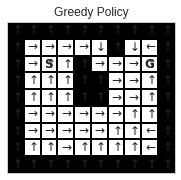

In [0]:
grid = Grid()
agent = ReplayQ_AGENT(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
# visualise the greedy policy
plot_greedy_policy(grid, q)

# RL Lab 2: REINFORCE Agent w/ FA 

Implement an agent that uses **REINFORCE** to learn action values, at each step:


**Initialize** $V(s), \pi(s,a)$ for all s ∈ S and a ∈ A(s)



In [0]:
!pip install -q dm-sonnet

In [0]:
import sonnet as snt

## 2.1 (Vanilla) REINFORCE

We are still trying to solve the control problem: estimate the policy that gives us a better long term (discounted) return:

$$G_t = \sum_{k=t+1} \gamma^{k-t-1}R_k $$

Objective:
$$J(\theta) = \mathbb{E}_{\pi_{\theta}} [G_t]$$


Using the log-derivative trick, we can obtain the gradient of $J(\theta)$ with respect to the policy parameters $\theta$ as:

$$\nabla_{\theta} J = \mathbb{E}_{{\pi_{\theta}}}[\sum_{t}\nabla_{\theta}\log \pi_{\theta}(s_t,a_t) G_t]$$

We estimate this gradient via sampling episodes in the enviroment.

Reference: See REINFORCE in Chapter 13: Policy Gradient Methods in [Book](https://drive.google.com/file/d/1xeUDVGWGUUv1-ccUMAZHJLej2C7aAFWY/view)

### 2.1.1 Build agent
This is slipt into two part:
* Build the Policy functional approximator
* Build the REINFORCE Agent

In [0]:
#@title Policy Approximator
#Define a class that build our policy approximation
class PolicyApproximator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, num_actions=4, learning_rate=0.01, scope="policy_approximation"):
        with tf.variable_scope(scope):
            # This is a function of the state V(state)
            self.state = tf.placeholder(tf.int32, [], "state")
            
            # Embbed the state into a one-hot coding
            state_one_hot = tf.one_hot(self.state[None, ...], int(grid._layout.size))

            # We are evaluating the policy of a (previously) selected action
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            
            # Return placeholder
            self.return_s = tf.placeholder(dtype=tf.float32, name="return")
            
            # Very simple (linear) transformation of the state to 
            # \pi_{\theta}(a|s) -- this is can be anything you think
            # your solution class needs to span the intermediate sol.
            nn_transform = snt.Linear(4,
                                      initializers={'w': tf.zeros_initializer,
                                                    'b': tf.zeros_initializer})
            self.output_layer = nn_transform(state_one_hot)
            
            # ============ YOUR CODE HERE =============
            # Compute pi(a=self.action|s) for a selected action
            # self.action_probs =
            
            # Define the loss
            # self.loss = 
            
            # Define an optimizer
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            # Define the training operation
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
      # ============ YOUR CODE HERE =============
      sess = sess or tf.get_default_session()
      # compute the probabilities of all actions given 
      # this state \pi(a|s) for all a.
      # pi_s = 
      return pi_s

    def update(self, state, return_s, action, sess=None):
      # ============ YOUR CODE HERE =============
      sess = sess or tf.get_default_session()
      # perform training/operation operation
      # compute and return the loss
      return loss

In [0]:
#@title REINFORCE Agent 
class REINFORCE_AGENT(object):
  
  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      policy_learning_rate=0.01, const_discount=1.0):
    
    self._policy_approximator = PolicyApproximator(num_actions=number_of_actions,
                                                   learning_rate=policy_learning_rate)
    self._constant_discount = const_discount 
    
    # initial state/action
    self._state = initial_state
    self._action = 0
    self.sess = tf.get_default_session()
    
  def step(self, state):
    # ============ YOUR CODE HERE =============
    # Get the action probabilities 
    # action_probs = 
    
    # Select you action
    # action = 
    
    # Update the internal variables
    self._action = action
    self._state = state
    return self._action
    
  def update(self, episode):
    # go over the all experience collected in this episode
    for t, transition in enumerate(episode):
      
      # ============ YOUR CODE HERE =============
      # Compute the (discounted) return
      # discounted_return = 
      
      # Update our policy estimator based on return
      # self._policy_approximator.update(...)
      
      pass


In [0]:
def run_reinforce(env, agent, num_episodes, MAXSTEPS_PER_EPISODE=100):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: gridworld
        agent: REINFORCE agent
        num_episodes: Number of episodes to run for
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    EpStats = namedtuple("EpStats", ["episode_lengths", "episode_rewards"])
    # Keeps track of useful statistics
    stats = EpStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "discount"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the first action
        action = 0#agent.initial_action()
        reward, discount, next_state = env.step(action)
        
        episode = []
        
        # One step in the environment
        state = next_state
        for t in range(MAXSTEPS_PER_EPISODE): 
            
            # Take a step
            action = agent.step(state)
            reward, discount, next_state = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, discount=discount))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if ((discount == 0) | (t==99)) & (i_episode%20==0):
                # Print out which step we're on, useful for debugging
                print("Episode {}/{}: Length {} ({})".format(
                i_episode + 1, num_episodes, t, stats.episode_rewards[i_episode - 1]))

            if discount == 0: # this signals end of the episode          
                break
                
            state = next_state
    
        # Go through the episode and make policy updates
        agent.update(episode)
      
    return stats

### 2.1.2. Run experiment
 Ready go! Let's test our agent!

In [0]:
# initialise an instance of the environment
grid = Grid(discount=1.0)

In [0]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

agent = REINFORCE_AGENT(number_of_states=grid._layout.size,
                        number_of_actions=4, 
                        initial_state=grid.get_obs(), 
                        policy_learning_rate=0.01, 
                        const_discount=1.0)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~500-1000 should be okay
    stats = run_reinforce(grid, agent, 500)

Episode 1/500: Length 99 (0.0)
Episode 21/500: Length 99 (-125.0)
Episode 41/500: Length 99 (-40.0)
Episode 61/500: Length 99 (-25.0)
Episode 81/500: Length 99 (-15.0)
Episode 101/500: Length 99 (-20.0)
Episode 121/500: Length 99 (0.0)
Episode 141/500: Length 99 (0.0)
Episode 161/500: Length 99 (0.0)
Episode 181/500: Length 99 (0.0)
Episode 201/500: Length 99 (-10.0)
Episode 221/500: Length 99 (0.0)
Episode 241/500: Length 99 (0.0)
Episode 261/500: Length 99 (0.0)
Episode 281/500: Length 99 (0.0)
Episode 301/500: Length 99 (0.0)
Episode 321/500: Length 99 (0.0)
Episode 341/500: Length 99 (0.0)
Episode 361/500: Length 99 (-5.0)
Episode 381/500: Length 99 (-500.0)
Episode 401/500: Length 99 (-80.0)
Episode 421/500: Length 99 (-15.0)
Episode 441/500: Length 99 (-10.0)
Episode 461/500: Length 99 (-5.0)
Episode 481/500: Length 99 (0.0)


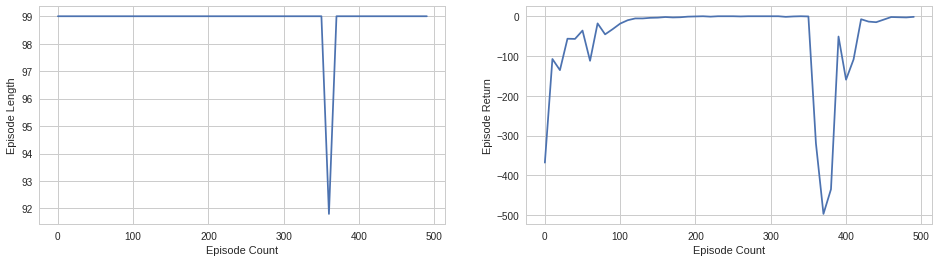

In [0]:
plot_stats(stats, window=10)

## 2.2 (Optional) Adding a baseline (via $V(s)$) 

### 2.2.1. Build the Agent
This is similar to the above agent, but now we have an additional problem of estimating/computing the value function $v(s)$.

Your tasks will be:
* Implement the value function approximator: prediction/update
* Adjust the above agent to include this baseline 
(Note: make sure you remember to update both your value and policy approx.)

In [0]:
#@title Value function approximator 
class ValueApproximator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_approximation"):
        with tf.variable_scope(scope):
          
            # This is a function of the state V(state)
            self.state = tf.placeholder(tf.int32, [], "state")
            # Embbed the state into a one-hot coding
            state_one_hot = tf.one_hot(self.state[None, ...], int(grid._layout.size))
            
            # ============ YOUR CODE HERE =============
            # Target Q-value function
            # self.target = ...
            
            # Very simple (linear) transformation of the state to 
            # the value function V_{\theta}(s) 
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            
            # ============ YOUR CODE HERE =============
            # Define the loss
            # self.loss = 
            
            # Define an optimizer
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            # Define the training operation
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
      sess = sess or tf.get_default_session()
      # ============ YOUR CODE HERE =============
      # v_s = 
      return v_s
    
    def update(self, state, target, sess=None):
      sess = sess or tf.get_default_session()
      # ============ YOUR CODE HERE =============
      # loss, _ =                                                self.target: target})
      return loss

In [0]:
#@title REINFORCE with baseline via estimating V(s)
class REINFORCE_AGENT(object):
  
  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      policy_learning_rate=0.01, value_learning_rate=0.1, const_discount=1.0,
      use_baseline=True):
    
    self._value_approximator  = ValueApproximator(learning_rate=value_learning_rate)
    self._policy_approximator = PolicyApproximator(learning_rate=policy_learning_rate)
    self._constant_discount = const_discount 
    
    # initial state/action
    self._state = initial_state
    self._action = 0
    self._use_baseline = use_baseline
    
  def step(self, state):
    # ============ YOUR CODE HERE =============
    # Note: you an COPY this from above
    # Select the action to send to the environment
    
    # Get the action probabilities 
    # action_probs = ...
    
    # Select you action
    #action = ...
    
    # Update the internal variables
    self._action = action
    self._state = state
    return self._action
    
  def update(self, episode):
     # go over the all experience collected in this episode
    for t, transition in enumerate(episode):
      # ============ YOUR CODE HERE =============
      # Compute the discounted return
      # discounted_return = 
      
      if self._use_baseline:
        # ============ YOUR CODE HERE =============
        # Compute baseline/advantage
        # baseline = 
        
        # Compute advantage
        # advantage = 
        
        # Update our value estimator
        # self._value_approximator.update(...)
        
        # Update our policy estimator
        # self._policy_approximator.update(...)
      else:
        # Update our policy estimator based on return
        # self._policy_approximator.update(...)
    
    

In [0]:
def run_reinforce(env, agent, num_episodes, MAXSTEPS_PER_EPISODE=100):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: gridworld
        agent: REINFORCE agent
        num_episodes: Number of episodes to run for
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    EpStats = namedtuple("EpStats", ["episode_lengths", "episode_rewards"])
    # Keeps track of useful statistics
    stats = EpStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "discount"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        action = 0#agent.initial_action()
        reward, discount, next_state = env.step(action)
        
        episode = []
        
        # One step in the environment
        state = next_state
        for t in range(MAXSTEPS_PER_EPISODE): 
            
            # Take a step
            action = agent.step(state)
            reward, discount, next_state = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, discount=discount))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if ((discount == 0) | (t==99)) & (i_episode%20==0):
                # Print out which step we're on, useful for debugging
                print("Episode {}/{}: Length {} ({})".format(
                i_episode + 1, num_episodes, t, stats.episode_rewards[i_episode - 1]))

            if discount == 0: # this signals end of the episode          
                break
                
            state = next_state
    
        # Go through the episode and make policy updates
        agent.update(episode)
      
    return stats

### 2.2.2. Run experiment

In [0]:
grid = Grid(discount=1.0)

In [0]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

agent = REINFORCE_AGENT(number_of_states=grid._layout.size,
                        number_of_actions=4, 
                        initial_state=grid.get_obs(), 
                        policy_learning_rate=0.01, 
                        value_learning_rate=0.1, 
                        const_discount=1.0,
                        use_baseline=False)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = run_reinforce(grid, agent, 500)

Episode 1/500: Length 99 (0.0)
Episode 21/500: Length 99 (-115.0)
Episode 41/500: Length 99 (-255.0)
Episode 61/500: Length 99 (-475.0)
Episode 81/500: Length 99 (-485.0)
Episode 101/500: Length 46 (0.0)
Episode 121/500: Length 30 (-35.0)
Episode 141/500: Length 53 (5.0)
Episode 161/500: Length 19 (10.0)
Episode 181/500: Length 28 (10.0)
Episode 201/500: Length 36 (10.0)
Episode 221/500: Length 49 (10.0)
Episode 241/500: Length 16 (10.0)
Episode 261/500: Length 22 (10.0)
Episode 281/500: Length 48 (5.0)
Episode 301/500: Length 25 (10.0)
Episode 321/500: Length 32 (10.0)
Episode 341/500: Length 16 (10.0)
Episode 361/500: Length 27 (10.0)
Episode 381/500: Length 32 (10.0)
Episode 401/500: Length 22 (10.0)
Episode 421/500: Length 18 (10.0)
Episode 441/500: Length 12 (10.0)
Episode 461/500: Length 27 (10.0)
Episode 481/500: Length 12 (10.0)


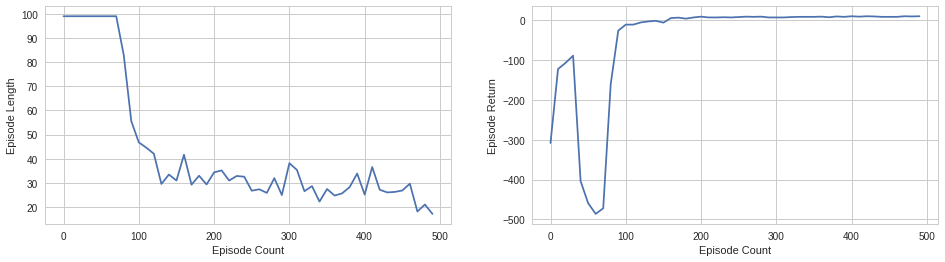

In [0]:
plot_stats(stats, window=10)